# Neural Network Classification in PyTorch

Classification is a problem of predicting whether something is one thing or another

### 1. Make classification data and get it ready

In [1]:
import sklearn

In [2]:
from sklearn.datasets import make_circles

# MAKE 1000 Samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [3]:
len(X), len(y)

(1000, 1000)

In [4]:
print(X[:5])

[[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]


In [5]:
print(y[:5])

[1 1 1 1 0]


In [6]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],"X2": X[:,1],"Label":y})

circles.head(10)

,X1,X2,Label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


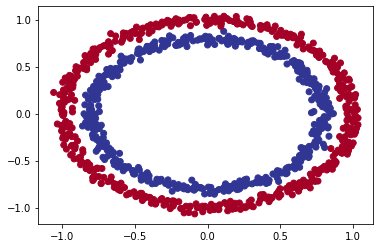

In [7]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],y=X[:,1], c=y, cmap=plt.cm.RdYlBu)

**Note**: The data we are working with is often referred to as a toy dataset, a dataset that is small enough to experiment but still sizable enough to practice the fundamentals.

### 1.1 Check input and output shapes

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [9]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]

print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X:{X_sample.shape} and the same for y:{y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X:(2,) and the same for y:()


### 1.2 Turn the data into tensors and create train and test splits

In [10]:
# Turn data into tensors
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
X.dtype, y.dtype

(torch.float32, torch.float32)

In [12]:
# Split data into train and test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=7)


In [13]:
len(X_train), len(X_test), len(y_train), len(y_test)
 

(800, 200, 800, 200)

## 2. Building a model

Lets build a model to classify our blue and red dots

To do so, we want to:
1. Setup device agnostic code so our code will run on on an accelerator (GPU) if there is one
2. Construct a model (by subclassing `nn.Module`)
3. Define a loss function and optimizer
4. Create a training and test loop

In [14]:
# Import PyTorch and nn
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [15]:
X_train

tensor([[ 1.0088,  0.1861],
        [-0.4627,  0.5702],
        [ 0.7037,  0.6843],
        ...,
        [ 0.5973,  0.8081],
        [-0.4875, -0.8637],
        [-0.1495, -0.9860]])

Now we have setup device agnostic code lets create a model that:

1. Subclass `nn.Module` (almost all models in PyTorch subclass `nn.Module`)
2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
3. Define a `forward()` method that outlines the forward pass (or forward computation)
4. Instantiate an instance of our model class and send it to the target device

In [16]:
X_train.shape

torch.Size([800, 2])

In [17]:
y_train[:5]

tensor([0., 1., 0., 1., 1.])

In [18]:
# 1. Construct a model that subclasses the nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 `nn.Linear()` layers that are capable of handling the shapes of our data
        self.layer1 = nn.Linear(in_features=2, out_features=5) # takes 2 features and upscales to 5 features
        self.layer2 = nn.Linear(in_features=5,out_features=1) # takes 5 features from previous layer and outputs a single feature(same shape as y)
    
    # 3. Define a forward method that outlines the forwrd pass
    def forward(self,x):
        return self.layer2(self.layer1(x)) # x -> layer1 -> layer2 -> output
    
    # Instantiate an instance of our model class and send it to desired device

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [19]:
device

'cuda'

In [20]:
next(model_0.parameters())

Parameter containing:
tensor([[ 0.5473, -0.4190],
        [-0.6223, -0.4573],
        [ 0.3161, -0.4601],
        [-0.4515, -0.2152],
        [ 0.2955, -0.6185]], device='cuda:0', requires_grad=True)

In [21]:
# Lets replicate the model above using nn.Sequential()
model_0 = nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [22]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3505,  0.3506],
                      [-0.6233,  0.5396],
                      [ 0.5188,  0.3655],
                      [-0.1932,  0.1585],
                      [-0.1307,  0.4890]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1356, -0.3696, -0.5542, -0.2868, -0.2373], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3885,  0.1669, -0.1256,  0.3027,  0.0855]], device='cuda:0')),
             ('1.bias', tensor([0.3946], device='cuda:0'))])

In [23]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\n First 10 predictions:\n {torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

 First 10 predictions:
 tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], device='cuda:0')

First 10 labels:
tensor([0., 0., 0., 1., 1., 0., 1., 1., 0., 0.])


### 2.1 Setup loss function and optimizer

Which loss function or optimizer should you use? --> problem specific

For example for regression you might want MAE or MSE (mean absolute or mean squared error)

For classification you might use binary crossentropy(log loss) or categorical cross entropy (cross entropy)

And for optimizers two of the most common are SGD and Adam however PyTorch has many more built-in options.

In [24]:
# Setup the loss function
# BCELoss() requires input to have gone through sigmoid before passing it in
loss_fn = nn.BCEWithLogitsLoss() # BCEWithLogitsLoss() has sigmoid activation function built-in

optimizer = torch.optim.SGD(params=model_0.parameters(),
                            lr=0.1)

In [25]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3505,  0.3506],
                      [-0.6233,  0.5396],
                      [ 0.5188,  0.3655],
                      [-0.1932,  0.1585],
                      [-0.1307,  0.4890]], device='cuda:0')),
             ('0.bias',
              tensor([ 0.1356, -0.3696, -0.5542, -0.2868, -0.2373], device='cuda:0')),
             ('1.weight',
              tensor([[-0.3885,  0.1669, -0.1256,  0.3027,  0.0855]], device='cuda:0')),
             ('1.bias', tensor([0.3946], device='cuda:0'))])

In [26]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred)) * 100
    return acc

# 3. Train model

Steps for training loop:
1. Forward pass
2. Calculate the loss
3. Optimizer zero grad
4. Loss backward (backward propagation)
5. Optimizer step

### 3.1 Going from raw logits -> prediction probabilities -> prediction labels
Our model outputs are going to be raw **logits**

We can convert these logits into prediction probabilities by passing them to some kind of activation function (e.g. sigmoid for binary classification and softmax for multiclass classification).

Then we can convert our model's prediction probabilities to prediction labels by either rounding them or taking the `argmax()`.

In [27]:
# View the first 5 outputs of the forward pass on the test data
with torch.inference_mode():
    y_logits = model_0(X_test.to(device))[:5]
y_logits

tensor([[0.3461],
        [0.1385],
        [0.2320],
        [0.1982],
        [0.2787]], device='cuda:0')

In [28]:
y_test[:5]

tensor([0., 0., 0., 1., 1.])

In [29]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilities
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.5857],
        [0.5346],
        [0.5577],
        [0.5494],
        [0.5692]], device='cuda:0')

For our prediction probability values, we need to perform a range-style rounding on them:
* y_pred_probs >= 0.5, y=1 (class 1)
* y_pred_probs <0.5, y=0 (class 0)

In [30]:
# Find the predicted labels 
y_preds = torch.round(y_pred_probs)

# In full (logits -> pred probs -> pred labels)
y_pred_labels = torch.round(torch.sigmoid(model_0(X_test.to(device)[:5])))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0')

In [31]:
y_test[:5]

tensor([0., 0., 0., 1., 1.])

### 3.2 Building a training and testing loop

In [32]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
epochs=100

# Put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_0.train()

    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    #loss = loss_fn(torch.sigmoid(y_logits),y_train) # BCELoss expects pred probs as inputs
    loss = loss_fn(y_logits, # BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_0(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 10 == 0:
        print(f"epoch:{epoch} | Loss:{loss:.5f} | Acc:{acc:2f}% | Test Loss:{test_loss:2f} | Test acc:{test_acc:2f}%")

epoch:0 | Loss:0.70028 | Acc:50.125000% | Test Loss:0.703251 | Test acc:49.500000%
epoch:10 | Loss:0.69556 | Acc:50.125000% | Test Loss:0.699403 | Test acc:49.500000%
epoch:20 | Loss:0.69381 | Acc:57.375000% | Test Loss:0.698015 | Test acc:59.500000%
epoch:30 | Loss:0.69317 | Acc:53.375000% | Test Loss:0.697494 | Test acc:49.000000%
epoch:40 | Loss:0.69294 | Acc:52.875000% | Test Loss:0.697265 | Test acc:45.500000%
epoch:50 | Loss:0.69285 | Acc:52.250000% | Test Loss:0.697132 | Test acc:46.000000%
epoch:60 | Loss:0.69282 | Acc:52.000000% | Test Loss:0.697032 | Test acc:45.000000%
epoch:70 | Loss:0.69280 | Acc:52.375000% | Test Loss:0.696946 | Test acc:42.000000%
epoch:80 | Loss:0.69279 | Acc:51.750000% | Test Loss:0.696869 | Test acc:42.000000%
epoch:90 | Loss:0.69279 | Acc:52.000000% | Test Loss:0.696801 | Test acc:42.000000%


## 4. Make predictions and evaluate model

From the metrics it looks like our model isnt learning anything...

So to inspect it lets make predictions and then visualize!

To do so, we are going to import a function called `plot_decision_boundary()`- https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py

In [33]:
import requests
from pathlib import Path

# Download helper functions from the repo 
if Path("helper_functions.py").is_file():
    print("helper_functions.py already exists, skipping download")
else:
    print("Downloading helper_functions.py")
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
    with open("helper_functions.py", "wb") as f:
        f.write(request.content)


from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


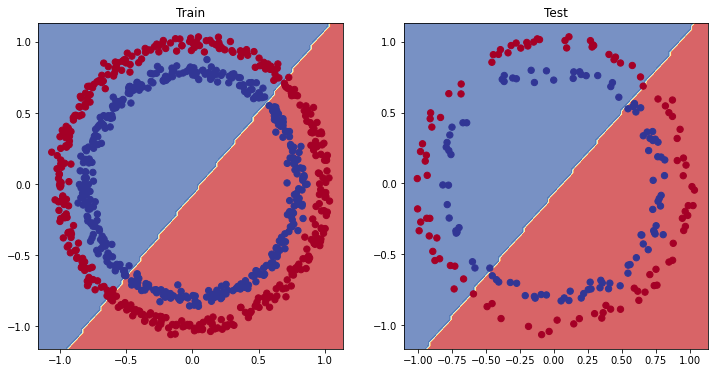

In [34]:
# plot decision boundary of the model
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test, y_test)

## 5. Improving a model (from a model perspective)

* Add more layers - give the model more chances to learn about patterns in the data
* Add more hidden units - go from 5 hidden units to 10 hidden units
* Fit for longer
* Changing the activation functions
* Change the learning rate
* Change the loss function
All these are **hyperparameters**

Changes we made to the model:
* Hidden units: 5 -> 10
* Layers: 2 -> 3
* Number of epochs: 100 -> 1000

In [35]:
model_0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.3623,  0.3464],
                      [-0.6176,  0.5416],
                      [ 0.5167,  0.3645],
                      [-0.1837,  0.1619],
                      [-0.1276,  0.4901]])),
             ('0.bias', tensor([ 0.1833, -0.3920, -0.5437, -0.3252, -0.2494])),
             ('1.weight',
              tensor([[-0.4142,  0.2001, -0.0408,  0.3355,  0.1160]])),
             ('1.bias', tensor([0.2747]))])

In [36]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)

    def forward(self,x):
        z = self.layer_1(x)
        z = self.layer_2(z)
        z = self.layer_3(z)

        return z

In [37]:
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [38]:
model_1.state_dict()

OrderedDict([('layer_1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188],
                      [ 0.6146,  0.1323],
                      [ 0.5224,  0.0958],
                      [ 0.3410, -0.0998],
                      [ 0.5451,  0.1045],
                      [-0.3301,  0.1802]], device='cuda:0')),
             ('layer_1.bias',
              tensor([-0.3258, -0.0829, -0.2872,  0.4691, -0.5582, -0.3260, -0.1997, -0.4252,
                       0.0667, -0.6984], device='cuda:0')),
             ('layer_2.weight',
              tensor([[ 0.2856, -0.2686,  0.2441,  0.0526, -0.1027,  0.1954,  0.0493,  0.2555,
                        0.0346, -0.0997],
                      [ 0.0850, -0.0858,  0.1331,  0.2823,  0.1828, -0.1382,  0.1825,  0.0566,
                        0.1606, -0.1927],
                      [-0.3130, -0.122

In [39]:
# Create a loss function
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(params = model_1.parameters(),lr=0.1)

In [40]:
# Write training and evaluation loop for model_1

torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs to 1000 from 100
epochs=1000

# Put data to target device
X_train,y_train = X_train.to(device), y_train.to(device)
X_test,y_test = X_test.to(device), y_test.to(device)

# Building training and evaluation loop
for epoch in range(epochs):
    ### Training
    model_1.train()

    # 1. Forward pass
    y_logits = model_1(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # turn logits -> pred probs -> pred labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_1.eval()
    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_1(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"epoch:{epoch} | Loss:{loss:.5f} | Acc:{acc:2f}% | Test Loss:{test_loss:2f} | Test acc:{test_acc:2f}%")

epoch:0 | Loss:0.69311 | Acc:52.000000% | Test Loss:0.695961 | Test acc:46.000000%
epoch:100 | Loss:0.69281 | Acc:51.875000% | Test Loss:0.696031 | Test acc:43.500000%
epoch:200 | Loss:0.69278 | Acc:52.375000% | Test Loss:0.696237 | Test acc:41.500000%
epoch:300 | Loss:0.69278 | Acc:51.500000% | Test Loss:0.696328 | Test acc:43.500000%
epoch:400 | Loss:0.69278 | Acc:51.625000% | Test Loss:0.696362 | Test acc:43.500000%
epoch:500 | Loss:0.69278 | Acc:51.750000% | Test Loss:0.696375 | Test acc:43.500000%
epoch:600 | Loss:0.69278 | Acc:51.750000% | Test Loss:0.696379 | Test acc:44.000000%
epoch:700 | Loss:0.69278 | Acc:51.750000% | Test Loss:0.696381 | Test acc:44.000000%
epoch:800 | Loss:0.69278 | Acc:51.625000% | Test Loss:0.696381 | Test acc:44.000000%
epoch:900 | Loss:0.69278 | Acc:51.625000% | Test Loss:0.696381 | Test acc:44.000000%


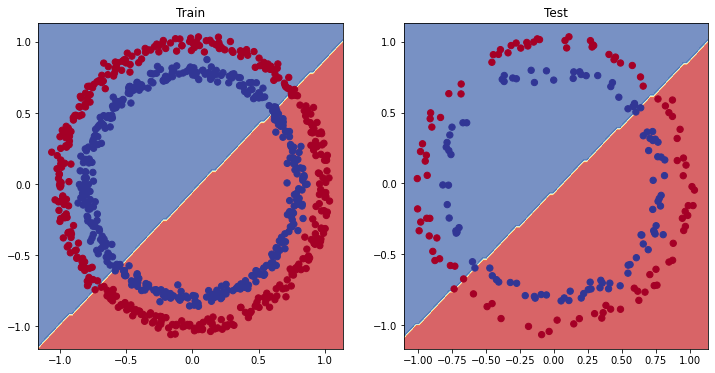

In [41]:
# Plot the decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1,X_test, y_test)

### 5.1 Preparing data to see if our model can fit a straight line

One way to troubleshoot to a larger problem is test out on a smaller problem

In [42]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression= torch.arange(start,end,step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # Linear regression formula (without epsilon)

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [43]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, X_test_regression = X_regression[:train_split], X_regression[train_split:]
y_train_regression, y_test_regression = y_regression[:train_split], y_regression[train_split:]

# Check the lengths of each
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

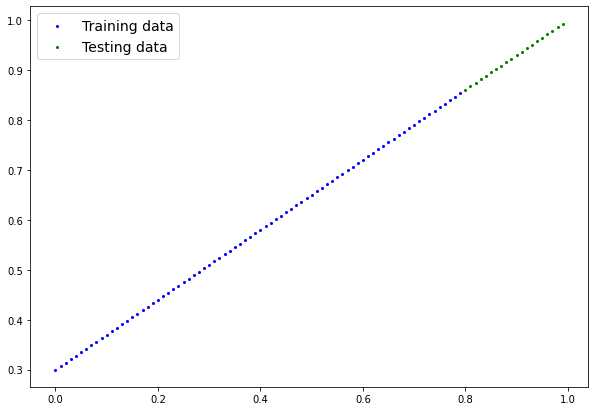

In [44]:
plot_predictions(train_data=X_train_regression, train_labels=y_train_regression, test_data=X_test_regression, test_labels=y_test_regression)

In [45]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [46]:
X_train_regression.shape

torch.Size([80, 1])

### 5.2 Adjusting `model_1` to fit a staright line

In [47]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [48]:
# Same architecture as model_1 (but using nn.Sequential())
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [49]:
# loss and optimizer

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params = model_2.parameters(), lr=0.01)

In [50]:
# train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs = 1000

# Put the data on the target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

# Training
for epoch in range(epochs):
    y_pred = model_2(X_train_regression)
    loss = loss_fn(y_pred, y_train_regression)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model_2.eval()
    with torch.inference_mode():
        test_pred = model_2(X_test_regression)
        test_loss = loss_fn(test_pred, y_test_regression)

    if epoch % 100 == 0:
        print(f"epoch:{epoch} | Loss:{loss:.5f} | Test Loss:{test_loss:2f}")

epoch:0 | Loss:0.75986 | Test Loss:0.911029
epoch:100 | Loss:0.02858 | Test Loss:0.000813
epoch:200 | Loss:0.02533 | Test Loss:0.002092
epoch:300 | Loss:0.02137 | Test Loss:0.003051
epoch:400 | Loss:0.01964 | Test Loss:0.003408
epoch:500 | Loss:0.01940 | Test Loss:0.003872
epoch:600 | Loss:0.01903 | Test Loss:0.003789
epoch:700 | Loss:0.01878 | Test Loss:0.003813
epoch:800 | Loss:0.01840 | Test Loss:0.003287
epoch:900 | Loss:0.01798 | Test Loss:0.003604


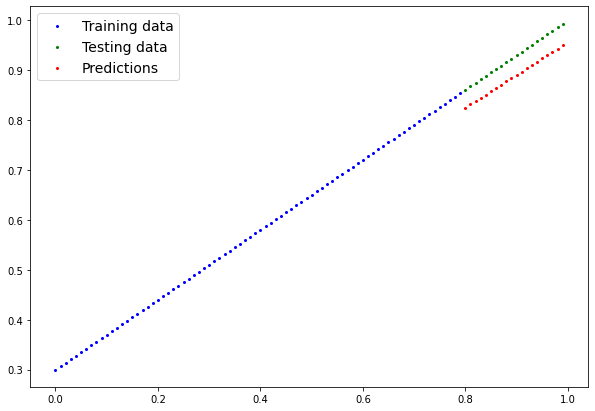

In [51]:
# turn on evaluation
model_2.eval()

# MAKE PREDICTIONS (INFERENCE)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

plot_predictions(train_data=X_train_regression.cpu(), train_labels=y_train_regression.cpu(),test_data=X_test_regression.cpu(),test_labels=y_test_regression.cpu(), predictions=y_preds.cpu())

## 6. The missing piece: non-linearity

What patterns could you draw if you were given an infinite amount of straight and non-straight lines?

Or in machine learning terms, an infinite (but really it is finite) of linear and non-linear functions?

### 6.1 Recreating non-linear data (red and blue)



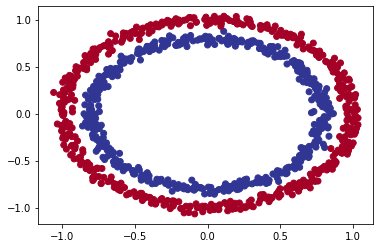

In [52]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)
plt.scatter(X[:,0],X[:,1], c=y, cmap=plt.cm.RdYlBu)

In [53]:
# Convert data to tensors and then to train and test splits
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([800, 2]),
 torch.Size([200, 2]),
 torch.Size([800]),
 torch.Size([200]))

### 6.2 Building a model with non-linearity

ANN are a large combination of linear and non-linear functions which are potentially able to find patterns in data.

In [54]:
# Build a model with non-linear activation functions
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10,out_features=1)
        self.relu = nn.ReLU() # non-linear activation function
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        # Where should we put our non-linear activation functions?
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

In [55]:
model_3 = CircleModelV2().to(device)
model_3

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

In [56]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(),
                            lr=0.1)

### 6.3 Training a model with non-linearity

In [57]:
# random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Put all data on target device 
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Loop through data
epochs = 1000

for epoch in range(epochs):
    ### Training
    model_3.train()

    # 1. Forward pass
    y_logits = model_3(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss/accuracy
    loss = loss_fn(y_logits, # BCEWithLogitsLoss expects raw logits as input
                   y_train)
    
    acc = accuracy_fn(y_true=y_train, y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward 
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_3.eval()

    with torch.inference_mode():
        # 1. Forward pass
        test_logits = model_3(X_test).squeeze()
        test_pred = torch.round(torch.sigmoid(test_logits))

        # 2. calculate test loss/acc
        test_loss = loss_fn(test_logits,
                            y_test)
        test_acc = accuracy_fn(y_true=y_test, y_pred=test_pred)

    if epoch % 100 == 0:
        print(f"epoch:{epoch} | Loss:{loss:.5f} | Acc:{acc:2f}% | Test Loss:{test_loss:2f} | Test acc:{test_acc:2f}%")

epoch:0 | Loss:0.69295 | Acc:50.000000% | Test Loss:0.693188 | Test acc:50.000000%
epoch:100 | Loss:0.69115 | Acc:52.875000% | Test Loss:0.691024 | Test acc:52.500000%
epoch:200 | Loss:0.68977 | Acc:53.375000% | Test Loss:0.689396 | Test acc:55.000000%
epoch:300 | Loss:0.68795 | Acc:53.000000% | Test Loss:0.687232 | Test acc:56.000000%
epoch:400 | Loss:0.68517 | Acc:52.750000% | Test Loss:0.684115 | Test acc:56.500000%
epoch:500 | Loss:0.68102 | Acc:52.750000% | Test Loss:0.679412 | Test acc:56.500000%
epoch:600 | Loss:0.67515 | Acc:54.500000% | Test Loss:0.672851 | Test acc:56.000000%
epoch:700 | Loss:0.66659 | Acc:58.375000% | Test Loss:0.663216 | Test acc:59.000000%
epoch:800 | Loss:0.65160 | Acc:64.000000% | Test Loss:0.647569 | Test acc:67.500000%
epoch:900 | Loss:0.62362 | Acc:74.000000% | Test Loss:0.621453 | Test acc:79.000000%


### 6.4 Evaluating a model trained with non-linear activation functions

In [58]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test))).squeeze()
y_preds[:10], y_test[:10]

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0'))

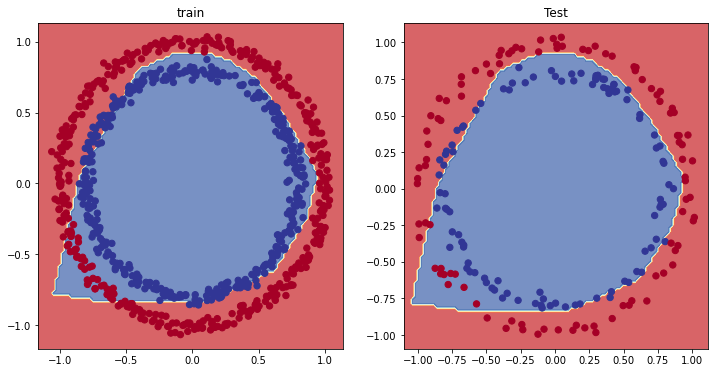

In [59]:
#  plot decision boundary
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model_3, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_3, X_test,y_test)

## 7. Replicating non-linear activations


In [60]:
# Create a tensor
A = torch.arange(-10,10,1, dtype=torch.float32)
A.dtype

torch.float32

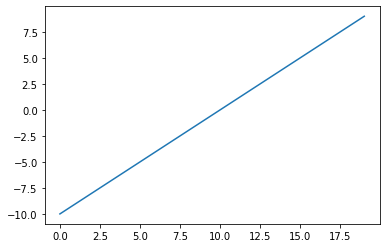

In [61]:
# Visualize the data
plt.plot(A)

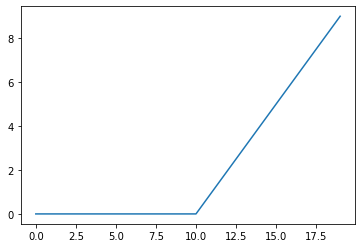

In [62]:
plt.plot(torch.relu(A))

In [63]:
def relu(x: torch.Tensor) -> torch.Tensor:
    return torch.maximum(torch.tensor(0),x)

In [64]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

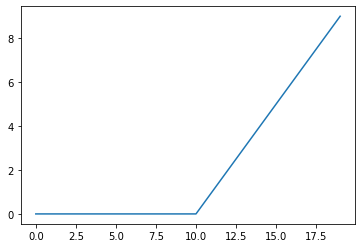

In [65]:
# plot ReLU activation function
plt.plot(relu(A))

In [66]:
def sigmoid(x:torch.Tensor) -> torch.Tensor:
    return 1/(1+ torch.exp(-x))

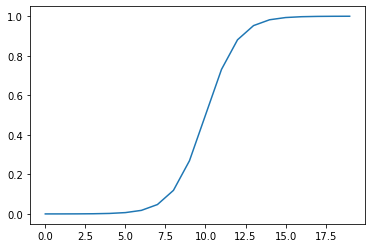

In [67]:
plt.plot(torch.sigmoid(A))

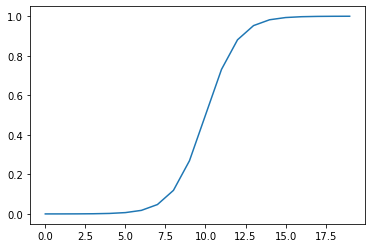

In [68]:
plt.plot(sigmoid(A))

## 8. Multi-class classification problem
* Binary Classification = one thing or another (cat vs dog, spam vs not spam, fraud or not)
* Multi-class classification = more than one thing or another (cat vs dog vs chicken)

### 8.1 Creating a toy multi-class classification

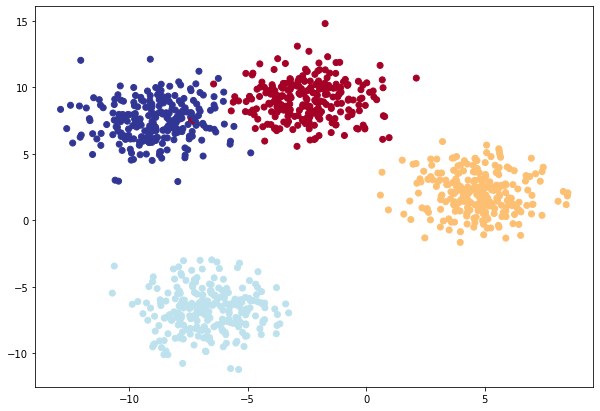

In [69]:
import torch
from torch import nn
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5, # give the clusters a little shake up
                            random_state=RANDOM_SEED)

# 2. turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split into train and test
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

# 4. Plot the data
plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1],c=y_blob, cmap=plt.cm.RdYlBu)

### 8.2 Building a multi-class classification model

In [70]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [71]:
# Build a multi-class classification model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8) -> None:
        """Initializes multi-class classification model.
        
        Args: 
        input_features (int): Number of input feaures to the model
        output_features (int): Number of output features (number of output classes)
        hidden_units (int): Number of hidden units between layers, default 8

        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )

    def forward(self, x):
        return self.linear_layer_stack(x)
    

# Create an instance of BlobModel and send it to target device
model_4 = BlobModel(input_features=2,
                    output_features=4,
                    hidden_units=8).to(device)

model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [72]:
X_blob_train.shape, y_blob_train.shape

(torch.Size([800, 2]), torch.Size([800]))

In [73]:
torch.unique(y_blob_train)

tensor([0, 1, 2, 3])

### 8.3 Creating loss functions and optimizers for multi-class classification

In [74]:
loss_fn = nn.CrossEntropyLoss()

# optimizer
optimizer = torch.optim.SGD(params=model_4.parameters(),
                            lr=0.1)

### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train our model we need to convert our model's outputs to prediction probabilities and then to prediction labels.

In [75]:
# Raw outputs
model_4.eval()
with torch.inference_mode():
    logits = model_4(X_blob_test.to(device))
logits

tensor([[-7.6459e-01, -7.4120e-01, -1.5777e+00, -1.1376e+00],
        [-9.7256e-02, -9.4310e-01, -5.9631e-01, -1.3715e-01],
        [ 2.5277e-01, -2.3794e-01,  1.8817e-01, -6.5686e-03],
        [-4.1340e-01, -5.2042e-01, -9.3033e-01, -6.9626e-01],
        [-3.1184e-01, -1.3736e+00, -1.1991e+00, -3.8337e-01],
        [-1.4971e-01, -1.0617e+00, -7.1069e-01, -1.6452e-01],
        [ 1.5388e-01, -2.8874e-01,  1.5199e-01, -1.0874e-02],
        [-2.1543e-01, -1.1795e+00, -9.3000e-01, -2.7448e-01],
        [ 2.4432e-01, -2.4716e-01,  1.6492e-01,  6.1044e-03],
        [-2.3286e-01, -1.2120e+00, -9.8487e-01, -3.0037e-01],
        [-1.7742e-01, -1.1008e+00, -8.2929e-01, -2.3689e-01],
        [-9.4082e-01, -7.8985e-01, -1.8480e+00, -1.3347e+00],
        [-2.9723e-01, -1.3458e+00, -1.1543e+00, -3.6287e-01],
        [-2.9006e-01, -1.3393e+00, -1.1146e+00, -3.3518e-01],
        [-3.3713e-01, -1.4374e+00, -1.2379e+00, -3.8029e-01],
        [-1.0260e-01, -9.5066e-01, -6.1913e-01, -1.5105e-01],
        

In [76]:
y_pred_probs = torch.softmax(logits, dim=1)
print(logits[:5])
print(y_pred_probs[:5])

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]], device='cuda:0')
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]], device='cuda:0')


In [77]:
torch.sum(y_pred_probs[0])

tensor(1., device='cuda:0')

In [78]:
torch.max(y_pred_probs[0])

tensor(0.3244, device='cuda:0')

In [79]:
torch.argmax(y_pred_probs[0])

tensor(1, device='cuda:0')

In [80]:
y_blob_test[0]

tensor(1)

In [81]:
# Convert our model's prediction probabilities to prediction labels
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')

In [82]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

In [83]:
torch.eq(y_blob_test.to(device), y_preds.to(device))

tensor([ True, False, False, False,  True, False, False,  True, False,  True,
         True,  True,  True,  True,  True, False, False, False, False, False,
        False,  True, False, False, False, False, False,  True, False,  True,
        False,  True, False, False,  True, False, False, False,  True, False,
         True, False, False, False,  True, False, False, False,  True,  True,
        False,  True, False, False, False, False, False,  True, False, False,
        False,  True, False, False, False,  True,  True, False, False,  True,
         True, False, False, False, False, False, False, False, False, False,
         True, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False,  True,  True, False, False,
         True,  True, False,  True, False, False, False,  True, False, False,
        False, False,  True, False, False, False,  True,  True, False, False,
        False, False,  True, False, False,  True,  True,  True, 

### 8.5 Create training and testing loop for a multi-class PyTorch model

In [84]:
# Fit the multi-class model to the data
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# set number of epochs
epochs = 100

# Put data on target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### TRAINING
    model_4.train()

    y_logits = model_4(X_blob_train).squeeze()
    y_pred = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)

    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train, y_pred=y_pred)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    ### TESTING
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_blob_test).squeeze()
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_blob_test)
        test_acc = accuracy_fn(y_true=y_blob_test,y_pred=test_preds)

    # Print
    if epoch % 10 == 0:
        print(f"epoch:{epoch} | Loss:{loss:.5f} | Acc:{acc:2f}% | Test Loss:{test_loss:2f} | Test acc:{test_acc:2f}%")

epoch:0 | Loss:1.15883 | Acc:40.375000% | Test Loss:1.075542 | Test acc:48.000000%
epoch:10 | Loss:0.64476 | Acc:96.750000% | Test Loss:0.660687 | Test acc:97.500000%
epoch:20 | Loss:0.42535 | Acc:98.500000% | Test Loss:0.430741 | Test acc:100.000000%
epoch:30 | Loss:0.25294 | Acc:99.125000% | Test Loss:0.245076 | Test acc:99.500000%
epoch:40 | Loss:0.11232 | Acc:99.250000% | Test Loss:0.102285 | Test acc:99.500000%
epoch:50 | Loss:0.06627 | Acc:99.250000% | Test Loss:0.058475 | Test acc:99.500000%
epoch:60 | Loss:0.05068 | Acc:99.250000% | Test Loss:0.042932 | Test acc:99.500000%
epoch:70 | Loss:0.04300 | Acc:99.250000% | Test Loss:0.034910 | Test acc:99.500000%
epoch:80 | Loss:0.03836 | Acc:99.250000% | Test Loss:0.029878 | Test acc:99.500000%
epoch:90 | Loss:0.03525 | Acc:99.250000% | Test Loss:0.026627 | Test acc:99.500000%


### 8.6 Making and evaluating predictions with multi-class model

In [85]:
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

y_logits[:10]

tensor([[-0.6249,  5.9860, -7.6323, -8.4470],
        [-2.1738, -6.3750, -3.7202,  3.1203],
        [-3.4102, -3.8958,  3.1567, -2.6119],
        [-1.1505,  4.1962, -3.8472, -4.8820],
        [ 3.7548, -1.3391, -9.1422, -6.9466],
        [-2.8211, -7.5767, -4.2944,  3.7944],
        [-3.0306, -3.3328,  2.7955, -2.1374],
        [ 3.3761, -4.0375, -6.8987, -3.5503],
        [-4.3620, -4.9904,  3.8123, -3.3814],
        [ 3.5012, -3.0281, -7.5401, -4.7064]], device='cuda:0')

In [86]:
y_pred_probs = torch.softmax(y_logits,dim=1)
y_pred_probs[:10]

tensor([[1.3438e-03, 9.9865e-01, 1.2164e-06, 5.3854e-07],
        [4.9905e-03, 7.4740e-05, 1.0630e-03, 9.9387e-01],
        [1.3985e-03, 8.6060e-04, 9.9463e-01, 3.1073e-03],
        [4.7389e-03, 9.9483e-01, 3.1956e-04, 1.1353e-04],
        [9.9388e-01, 6.0966e-03, 2.4904e-06, 2.2378e-05],
        [1.3372e-03, 1.1504e-05, 3.0644e-04, 9.9834e-01],
        [2.9138e-03, 2.1537e-03, 9.8781e-01, 7.1181e-03],
        [9.9838e-01, 6.0198e-04, 3.4435e-05, 9.7989e-04],
        [2.8147e-04, 1.5016e-04, 9.9882e-01, 7.5044e-04],
        [9.9825e-01, 1.4575e-03, 1.5998e-05, 2.7210e-04]], device='cuda:0')

In [87]:
y_pred_labels = torch.argmax(y_pred_probs, dim=1)
y_pred_labels[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

In [88]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0], device='cuda:0')

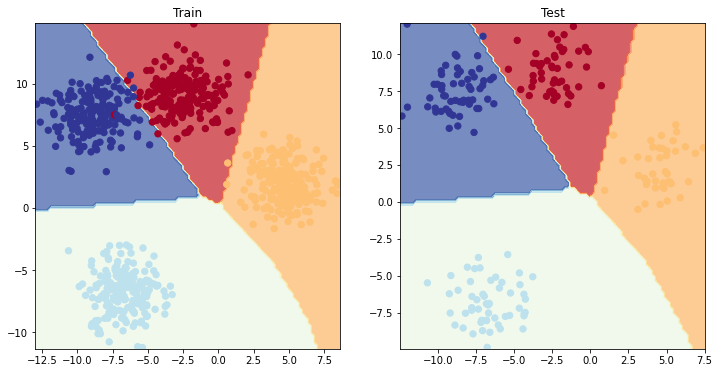

In [89]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4,X_blob_train,y_blob_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4,X_blob_test,y_blob_test)


## 9. More classification evaluation metrics
* Accuracy- Out of a 100 samples how many our model can get right?
* Precision
* Recall
* F1-Score
* Confusion Matrix
* Classification report

**Note:** Accuracy is not the best metric for imbalanced datasets

In [90]:
"""from torchmetrics import Accuracy

# Setup metric
torchmetric_accuracy = Accuracy(task='multilabel').to(device)

# Calculate accuracy
torchmetric_accuracy(y_preds, y_blob_test)"""

"from torchmetrics import Accuracy\n\n# Setup metric\ntorchmetric_accuracy = Accuracy(task='multilabel').to(device)\n\n# Calculate accuracy\ntorchmetric_accuracy(y_preds, y_blob_test)"